# Example of loading data and their visualizaition

To try this example, download [a sample data package](https://arcspace.jp/lib/exe/fetch.php?media=aigis2:itokawa_sample_for_pyaigis.zip) and place an unzipped folder with the same place as this notebook. The sample data is originally prepared as an sample data for the stand-alone application version of [AiGIS](https://arcspace.jp/doku.php?id=aigis:top), and a gravity vector data is added.

## 1. Import required modules

In [1]:
import pyvista as pv
import pyvistaqt as pvqt
import vtk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import spiceypy as spice

## 2. Load shape models in the OBJ format

In [2]:
obj_low = "./Itokawa_sample/Shapemodel/Itokawa_49152.obj"
mesh_low = pv.read(obj_low)

In [3]:
obj_high = "./Itokawa_sample/Shapemodel/Itokawa_3145728.obj"
mesh_high = pv.read(obj_high)

## 3. Define a function to generate lat/lon grid data

In [4]:
def latlon_grid(mesh, lat_interval, lon_interval):
    lat_grid = {}
    lon_grid = {}
    
    plane = pv.Plane(direction=(0,0,1)).triangulate()
    cutter = vtk.vtkCutter()
    implicitFunction = vtk.vtkImplicitPolyDataDistance()
    implicitFunction.SetInput(plane)
    cutter.SetInputData(mesh)
    cutter.SetCutFunction(implicitFunction)
    
    lat_grid[0] = cutter
    
    for lat in range(0, 90, lat_interval):
        if lat != 0:
            cone1 = pv.Cone(center=(0,0,0.5),direction=(0,0,-1),angle=lat, resolution=30).triangulate()
            cone = pv.Cone(center=(0,0,-0.5),direction=(0,0,1),angle=lat, resolution=30).triangulate()

            cutter = vtk.vtkCutter()
            implicitFunction = vtk.vtkImplicitPolyDataDistance()
            implicitFunction.SetInput(cone)
            cutter.SetInputData(mesh)
            cutter.SetCutFunction(implicitFunction)
            
            cutter1 = vtk.vtkCutter()
            implicitFunction1 = vtk.vtkImplicitPolyDataDistance()
            implicitFunction1.SetInput(cone1)
            cutter1.SetInputData(mesh)
            cutter1.SetCutFunction(implicitFunction1)
            

            lat_grid[lat] = cutter1
            lat_grid[lat*(-1)] = cutter
            
            
    for lon in range(0, 180, lon_interval):
        plane = pv.Plane(direction=(1, math.tan(math.radians(lon)), 0)).triangulate()
        
        cutter = vtk.vtkCutter()
        implicitFunction = vtk.vtkImplicitPolyDataDistance()
        implicitFunction.SetInput(plane)
        cutter.SetInputData(mesh)
        cutter.SetCutFunction(implicitFunction)
        
        lon_grid[lon] = cutter
        

    lat_grid = dict(sorted(lat_grid.items()))
    
    return lat_grid, lon_grid

### 3.1. Generate lat/lon grid data from shape models

In [5]:
lat_grid, lon_grid = latlon_grid(mesh_low, 10, 10)

In [6]:
lat_grid_high, lon_grid_high = latlon_grid(mesh_high, 10, 10)

## 4. Load mapdata (geographic information) from data files to a Pandas Dataframe

In [7]:
mapdata = pd.DataFrame() 

In [8]:
mapdata_dir = "./Itokawa_sample/MapData/"
for mapdata_file in glob.glob(mapdata_dir + "*.txt"):
    print(mapdata_file)
    with open(mapdata_file,'r') as file:
        data_count = file.readlines()[2]
        fin = int(data_count) + 3
    file.close()
    
    
    map = []
    
    
    with open(mapdata_file,'r') as file:
    
        for  line in file.readlines()[3:fin]:
            row = []
            toks = line.split()
            if toks[1] == '-' :
                map.append(np.nan)
            else:
                map.append(float(toks[1]))

    file.close()
    map = np.array(map)
    
    file = open(mapdata_file, 'r')
    label = file.readline()
    label = label.replace("\n","")
    file.close()
    mapdata[label] = map

./Itokawa_sample/MapData/Itokawa_elevation_64.txt
./Itokawa_sample/MapData/AMICA_brightness.txt
./Itokawa_sample/MapData/Lidar_Shot_count.txt
./Itokawa_sample/MapData/itokawa_Gpotential20110111.txt
./Itokawa_sample/MapData/itokawa_slope20110111.txt
./Itokawa_sample/MapData/NIRS_ch30_11_1_13.txt
./Itokawa_sample/MapData/st_2422543206_v_map64.txt


### Examine a mapdata

In [9]:
mapdata

,Elevation,AMICA_Brightness,LIDAR_Shot_count,Gravitational_Potential,Surface_Slope,NIRS_Albedo,st_2422543206
0,-3.451888,2208.0,12.0,1.332124e-08,8.327451,0.136988,NaN
1,-3.431725,2320.0,14.0,1.331943e-08,9.677955,0.137103,NaN
2,-3.906290,2400.0,18.0,1.336465e-08,19.696030,0.137116,NaN
3,-4.018442,2304.0,6.0,1.337372e-08,16.515810,0.137244,NaN
4,-4.496425,2320.0,21.0,1.341490e-08,8.457731,0.137221,NaN
...,...,...,...,...,...,...,...
49147,-13.372890,2672.0,5.0,1.402295e-08,20.296640,0.139043,NaN
49148,-13.574630,2576.0,5.0,1.403639e-08,16.779950,0.139327,NaN
49149,-13.981460,2528.0,9.0,1.407219e-08,18.056780,0.139327,NaN
49150,-13.653220,2592.0,4.0,1.404182e-08,17.979880,0.138906,NaN


## 5. Visualizarion of the models
### 5.1. Show a shape model in the notebook

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


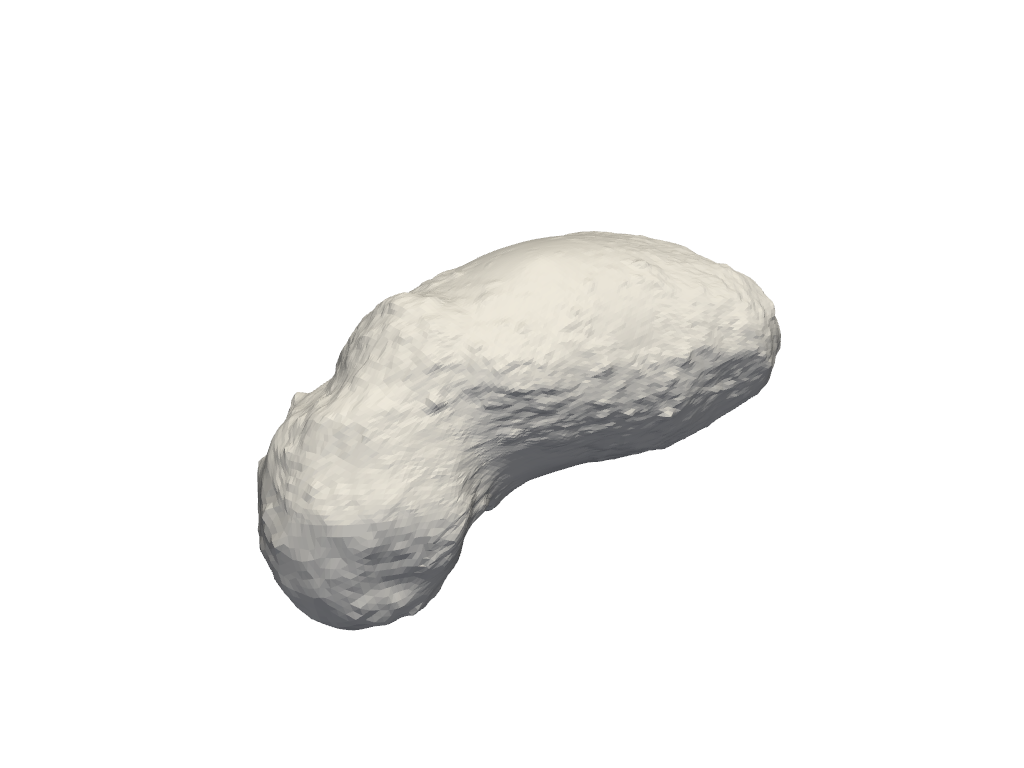

In [10]:
p = pv.Plotter()
p.add_mesh(mesh_low, color="w")
p.show()

### 5.2. Show a model with lat/lon grids

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


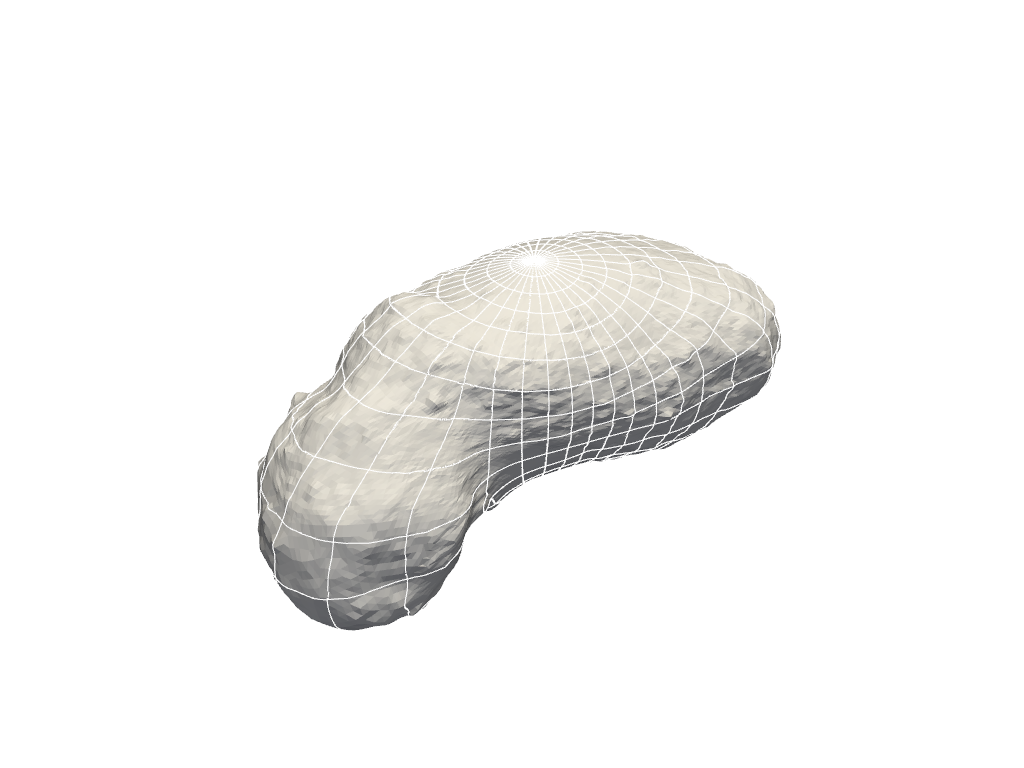

In [11]:
p = pv.Plotter()
p.add_mesh(mesh_low, color="w")
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.show()

### 5.3 Show a high-resolution model
This may take some time to get a result.

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


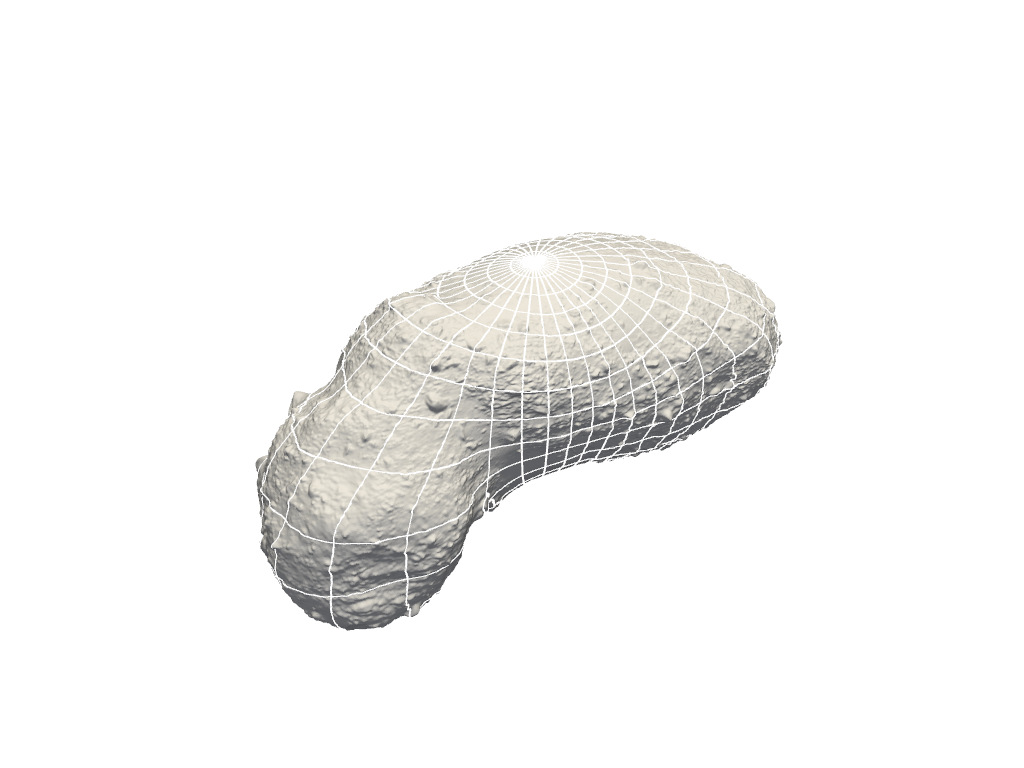

In [12]:
p = pv.Plotter()
p.add_mesh(mesh_high, color="w")
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid_high.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid_high.values())]
p.show()

## 6. Interactive visualization
### 6.1. Show a model in an interactive view with PyVistaQt

The PyVista window is persistent, you can continue without closing the window.

In [13]:
p = pvqt.BackgroundPlotter(notebook=False)
p.background_color= 'black'
p.add_mesh(mesh_low, color='w')
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.show()

This will obtain a view like [this snapshot](./img/ex1_6.1.png).

### Important note for macOS user
ipykernel will crush when a separate window with "notebook=False" is made by PyVista pv.Plotter and close it on macOS environment.
Curiously, this problem can be suppressed once a separate window is made by PyVistaQt pvqt.BackgroundPlotter before to call PyVista pv.Plotter.

### 6.2. Show a model in an interactive view with PyVista

PyVista window is not persistent, you have to close the window to continue.

In [14]:
p = pv.Plotter(notebook=False)
p.background_color= 'black'
p.add_mesh(mesh_low, color='w')
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.show()

This will obtain a view like [this snapshot](./img/ex1_6.2.png).

## 7. User defined viewing lighting geometries
### 7.1 Make a view with user defined viewing lighting geometries

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


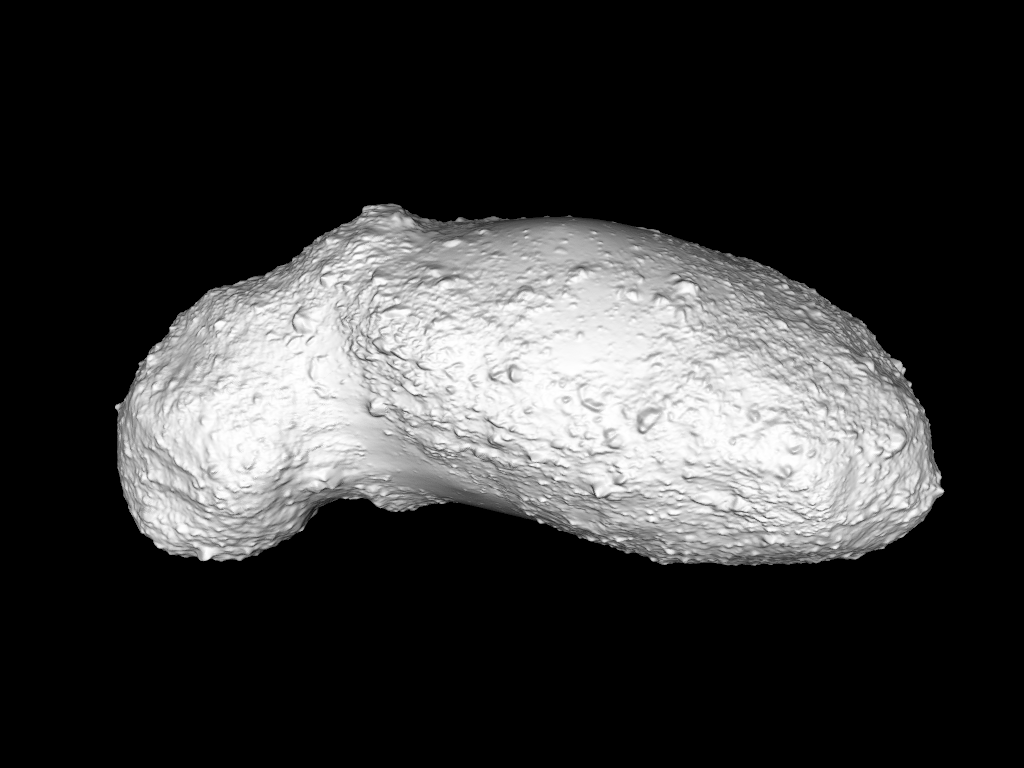

In [15]:
radius = 1.0
light_lat = 30
light_lon = 90
light_pos = spice.latrec(10, spice.rpd()*light_lon, spice.rpd()*light_lat)
camera_lat = 30
camera_lon = 90
camera_pos = spice.latrec(radius, spice.rpd()*camera_lon, spice.rpd()*camera_lat)

p = pv.Plotter(lighting='none')
# p = pv.Plotter(notebook=False, lighting='none')
p.background_color= 'black'
light = pv.Light(position=light_pos, color='w')
light.positional = True
p.add_mesh(mesh_high, color='w')
# [p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid_high.values())]
# [p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid_high.values())]
p.add_light(light)
# p.camera_position = 'zx' # quick difinition of the camera position 
# p.camera.position = (1.0, 1.0, 1.0)
p.camera.position = camera_pos.tolist()
p.show()

### 7.2. Interactive version of 7.1.

In [16]:
radius = 1.0
light_lat = 30
light_lon = 90
light_pos = spice.latrec(10, spice.rpd()*light_lon, spice.rpd()*light_lat)
camera_lat = 30
camera_lon = 90
camera_pos = spice.latrec(radius, spice.rpd()*camera_lon, spice.rpd()*camera_lat)

# p = pv.Plotter(lighting='none')
p = pv.Plotter(notebook=False, lighting='none')
p.background_color= 'black'
light = pv.Light(position=light_pos, color='w')
light.positional = True
p.add_mesh(mesh_high, color='w')
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid_high.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid_high.values())]
p.add_light(light)
# p.camera_position = 'zx' # quick difinition of the camera position 
p.camera.position = camera_pos.tolist() # camera postion should be a list
p.show()

This will obtain a view like [this snapshot](./img/ex1_7.2.png).

## 8. Visualization with mapdata (geographic information)
### 8.1 Show a model with slope data

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/homebrew/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


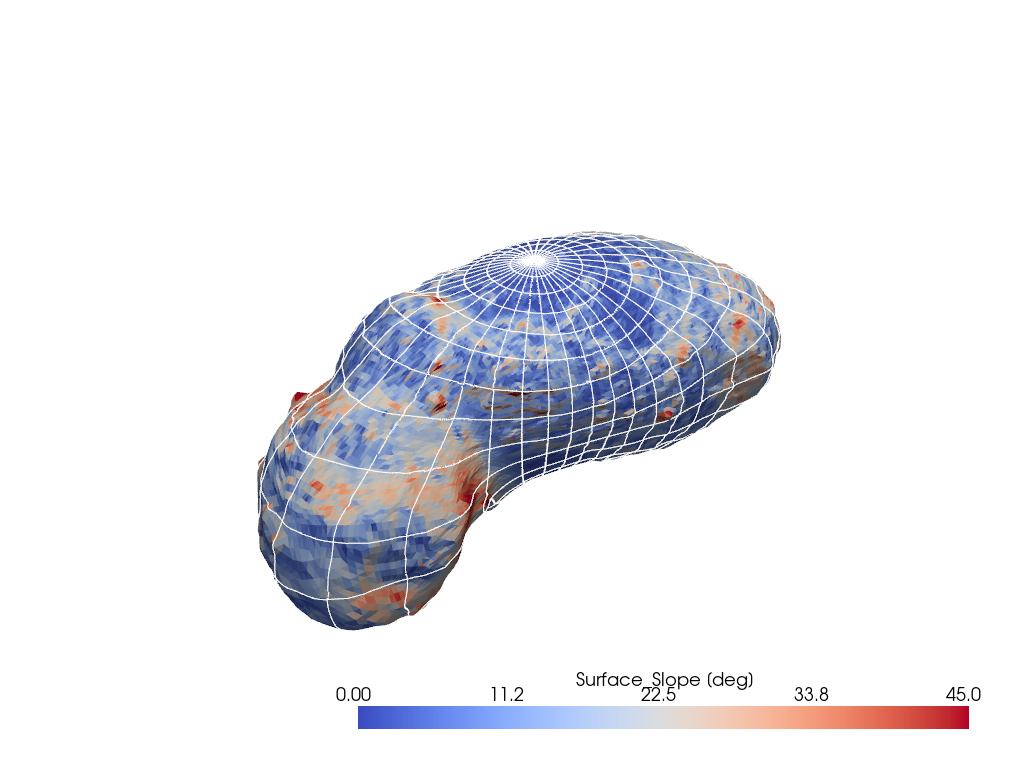

In [17]:
p = pv.Plotter()
# p = pv.Plotter(notebook=False)
p.add_mesh(mesh_low, scalars=mapdata["Surface_Slope"], cmap="coolwarm",
           scalar_bar_args={'title': 'Surface_Slope [deg]'},
           clim=[0, 45])
p.add_scalar_bar(title='Surface_Slope [deg]')
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.show()

### 8.2. Interactive version of 8.1.

In [18]:
# p = pv.Plotter()
p = pv.Plotter(notebook=False)
p.add_mesh(mesh_low, scalars=mapdata["Surface_Slope"], cmap="coolwarm",
           scalar_bar_args={'title': 'Surface_Slope [deg]'})
p.add_scalar_bar(title='Surface_Slope [deg]')
[p.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]
p.show()

This will obtain a view like [this snapshot](./img/ex1_8.2.png).

## 9. Multiple and synchronized view
### 9.1. PyVista version

In [19]:
p0 = pv.Plotter(shape=(2, 2), notebook=False, window_size=[2400,1600])
p0.subplot(0, 0)
p0.add_axes()
p0.add_text("High-res mesh", font_size=15)
p0.link_views()
p0.add_mesh(mesh_high, color='lightgrey',
           copy_mesh=True)
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid_high.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid_high.values())]

p0.subplot(0, 1)
p0.add_axes()
p0.add_text("Low-res mesh", font_size=15)
p0.add_mesh(mesh_low, color='lightgrey',
           copy_mesh=True)
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.subplot(1, 0)
p0.add_axes()
p0.add_text("Surface_Slope", font_size=15)
p0.add_mesh(mesh_low, scalars=mapdata["Surface_Slope"], cmap="coolwarm",
           scalar_bar_args={'title': 'Surface_Slope [deg]'},
           copy_mesh=True)
p0.add_scalar_bar(title='Surface_Slope [deg]')
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.subplot(1, 1)
p0.add_axes()
p0.add_text("Elevation", font_size=15)
p0.add_mesh(mesh_low, scalars=mapdata["Elevation"],
           scalar_bar_args={'title': 'Elevation [m]'},
           copy_mesh=True)
p0.add_scalar_bar(title='Elevation [m]')
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.show()

This will obtain a view like [this snapshot](./img/ex1_9.1.png).

### 9.2. PyVistaQt version

In [20]:
p0 = pvqt.BackgroundPlotter(shape=(2, 2), notebook=False)
p0.subplot(0, 0)
p0.add_axes()
p0.add_text("High-res mesh", font_size=15)
p0.link_views()
p0.add_mesh(mesh_high, color='lightgrey',
           copy_mesh=True)
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid_high.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid_high.values())]

p0.subplot(0, 1)
p0.add_axes()
p0.add_text("Low-res mesh", font_size=15)
p0.add_mesh(mesh_low, color='lightgrey',
           copy_mesh=True)
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.subplot(1, 0)
p0.add_axes()
p0.add_text("Surface_Slope", font_size=15)
p0.add_mesh(mesh_low, scalars=mapdata["Surface_Slope"], cmap="coolwarm",
           scalar_bar_args={'title': 'Surface_Slope [deg]'},
           copy_mesh=True)
p0.add_scalar_bar(title='Surface_Slope [deg]')
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.subplot(1, 1)
p0.add_axes()
p0.add_text("Elevation", font_size=15)
p0.add_mesh(mesh_low, scalars=mapdata["Elevation"],
           scalar_bar_args={'title': 'Elevation [m]'},
           copy_mesh=True)
p0.add_scalar_bar(title='Elevation [m]')
[p0.add_mesh(x, line_width=2, color="w") for x in list(lat_grid.values())]
[p0.add_mesh(x, line_width=2, color="w") for x in list(lon_grid.values())]

p0.show()

This will obtain a view like [this snapshot](./img/ex1_9.2.png).